## Dépendance logicielle

Ce notebook dépend des bibliothèques suivantes :
- Python3: pandas, numpy, scipy, matplotlib, time, cv2, os

In [1]:
%matplotlib inline
import numpy as np
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt
import time
import os
import sys
import pandas as pd
import cv2

In [2]:
import IPython
print(IPython.sys_info())
np.__version__

{'commit_hash': 'b467d487e',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/usr/lib/python3/dist-packages/IPython',
 'ipython_version': '5.5.0',
 'os_name': 'posix',
 'platform': 'Linux-4.2.0-1-amd64-x86_64-with-debian-stretch-sid',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.6.3 (default, Oct  3 2017, 21:16:13) \n[GCC 7.2.0]'}


'1.13.1'

# Partie A: Données synthétiques

## Question 1

In [3]:
def ratios(nb_data, nb_requests, dim):
    """
    Renvoie la table de données des ratios entre les 
    distances aux données les plus proches et les plus 
    lointaines de chaque requête aléatoire.
    """ 
    t0 = time.clock() # calcule le temps processeur et non le temps physique.
    x = np.random.randn(nb_data,dim) # tableau des données
    y = np.random.randn(nb_requests,dim) # tableau des requêtes
    z = dist.cdist(y,x,'euclidean') # matrice des distances euclidiennes
    minimums = z.min(1)
    maximums = z.max(1)
    time_taken = time.clock() - t0
    return pd.DataFrame({'Ratios' : (minimums/maximums).tolist(), 
                         'Elapsed' : time_taken, 
                         'N' : nb_data, 
                         'D' : dim})

def ratios_dataframe(nb_data, nb_requests, exp_end):
    """
    Concatène les tables de données obtenues pour les 
    différentes dimensions.
    """
    results = []
    frames = []

    for i in range(4, exp_end+1):
        dim = 2 ** i
        frames.append(ratios(nb_data, nb_requests, dim))
    return pd.concat(frames)

def plot_ratios(res, nb_data, nb_requests, exp_end):
    """
    Affiche le graphique des ratios obtenus pour 
    chaque dimension et leurs moyennes.
    """
    means = []
    jitter = np.random.rand(nb_requests) 
    # bruit sur l'abscisse permet de lire plus facilement le graphique 
    
    for i in range(4, exp_end+1):
        dim = 2 ** i
        x = (jitter - 0.5) * .5 + i 
        y = res['Ratios'][(res['D'] == dim)].values
        # tableau des ratios obtenus en dimension dim
        plt.plot(x, y, 'b.', markersize = .3)
        means.append(np.mean(y))

    avg, = plt.plot(np.arange(4, exp_end+1), means, linewidth= 1, color = 'red')
    plt.axhline(y=1, color='black', linestyle='-', linewidth = 1)

    plt.title("Ratios as a function of the dimension \n (" +
              str(nb_requests) + " requests for " +
              str(nb_data) + " points)")
    plt.xlabel("Logarithm of the dimension")
    plt.ylabel("Ratios")
    plt.legend([avg], ["Average"])
    plt.show()

def plot_time(res, nb_data, nb_requests, exp_end):
    """
    Affiche le graphique du temps de calcul des 
    ratios en fonction de la dimension des vecteurs.
    """
    times = []

    for i in range(4, exp_end+1):
        dim = 2 ** i
        y = results['Elapsed'][(results['D'] == dim)].values[0]
        # y est le temps de calcul pour la dimension dim
        times.append(y)

    plt.plot([2**i for i in range(4, exp_end +1)], times, linewidth= 1, color = 'red')
    plt.title("Time to compute the ratios as a function of the dimension \n (" + 
              str(nb_requests) + " requests for " +
              str(nb_data) + " points)")
    plt.xlabel("Dimension")
    plt.ylabel("Time in seconds")
    plt.show()

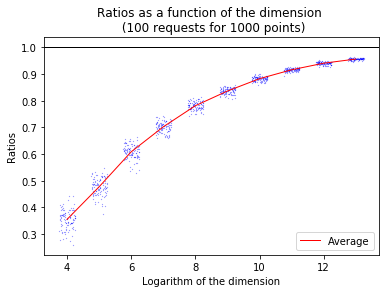

In [4]:
N=1000
M=100
exp_end = 13

results = ratios_dataframe(N, M, exp_end)
plot_ratios(results, N, M, exp_end)

Nous conjecturons que le ratio moyen tend vers 1 à N et M fixé quand la dimension augmente. C'est la "malédiction de la dimensionalité".

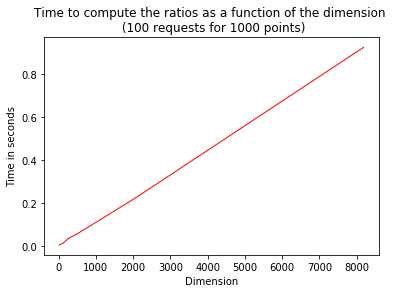

In [5]:
plot_time(results, N, M, exp_end)

La compléxité semble bien linéaire en la dimension.

Mêmes calculs avec N plus grand.

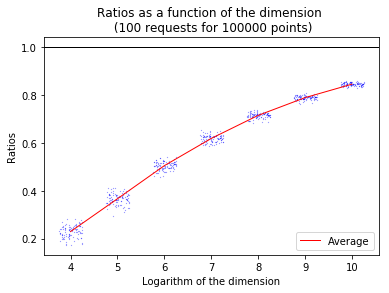

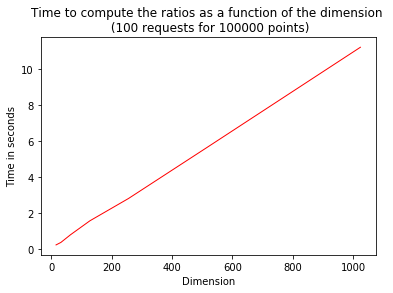

In [6]:
N = 10**5
results = ratios_dataframe(N, M, 10)
plot_ratios(results, N, M, 10)
plot_time(results, N, M, 10)

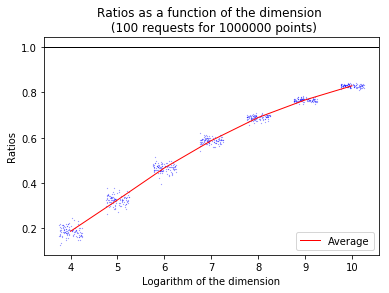

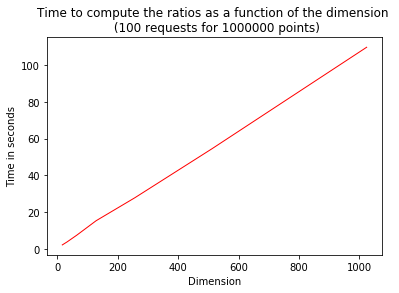

In [7]:
N = 10**6
results = ratios_dataframe(N, M, 10)
plot_ratios(results, N, M, 10)
plot_time(results, N, M, 10)

Nous remarquons plusieurs choses: premièremement, les ratios semblent moins dispersés autour de la valeur moyenne quand N augmente.<br />
De plus, le ratio moyen est plus faible quand le nombre de données augmente.<br />
Le temps de calcul reste bien linéaire (dans une certaine mesure du moins: nous n'avons calculé les ratios que jusqu'à des dimensions inférieures à 2^10, l'utilisation du swap augmentant considérablement le temps des calculs au dela).<br />

## Question 2

In [8]:
def random_norm_pos(n, dim):
    """
    Crée n vecteurs répartis uniformément sur le cadran positif 
    l'enveloppe  de l'hypersphère unité de dimension dim.
    """
    mean = np.zeros(dim)
    cov = np.identity(dim)
    x = np.random.multivariate_normal(mean, cov, n) 
    # x contient n vecteurs distribués selon une loi 
    # normale N(0,1) indépendamment sur chaque axe.
    normed_x = x / np.linalg.norm(x, axis=-1)[:, np.newaxis]
    positiv_x = np.asarray(list(map(np.absolute, normed_x)))
    return positiv_x

In [9]:
N = 1000
M = 100
D = 32

points = random_norm_pos(N,D)
requests = random_norm_pos(M, D)

## Question 3 

In [10]:
N= 1000
M = 100
exp_end = 10

In [11]:
def ratios_hypersphere_pos(nb_data, nb_requests, dim):
    """
    Calcul les ratios pour des données et requêtes, 
    répartis uniformément sur le cadran 
    positif de dimension dim.
    """
    t0 = time.clock() 
    x = random_norm_pos(nb_data, dim)
    y = random_norm_pos(nb_requests, dim) 
    z = dist.cdist(y,x,'euclidean') 
    minimums=z.min(1)
    maximums=z.max(1)
    time_taken = time.clock() - t0
    return pd.DataFrame({'Ratios' : (minimums/maximums).tolist(), 
                         'Elapsed' : time_taken, 
                         'N' : nb_data, 
                         'D' : dim})

def ratios_hypersphere_dataframe(nb_data, nb_requests, exp_end):
    """Concatène les tables de données obtenues pour les différentes dimensions."""
    results = []
    frames = []

    for i in range(4, exp_end+1):
        dim = 2 ** i
        frames.append(ratios_hypersphere_pos(nb_data, nb_requests, dim))
    return pd.concat(frames)

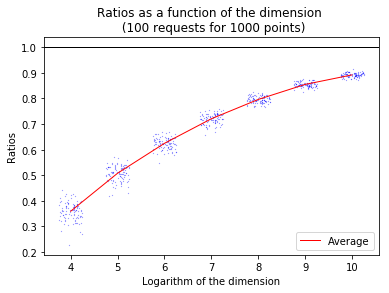

In [12]:
results = ratios_hypersphere_dataframe(N, M, exp_end)
plot_ratios(results, N, M, exp_end)

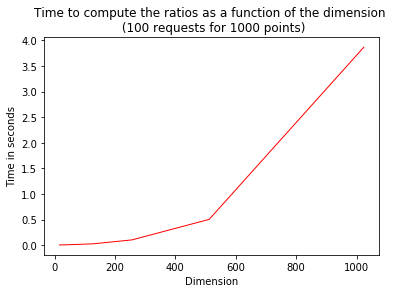

In [13]:
plot_time(results, N, M, exp_end)

La complexité n'est plus linéaire, en effet, lors de la création des vecteurs, nous créons une matrice de covariance, la complexité devient donc quadratique.

## Question 4 

### Hub 

Nous pouvons supposer que le vecteur de dimension D dont toutes les composantes sont égales est un hub. 

Cette hypothèse vient du raisonnement suivant:<br />
Notons SHP le cadran positif de l'hypersphère unité de dimension D,<br />
Soit v l'unique vecteur de SHP sont toutes les composantes sont égales.<br />
Alors v minimise max{|v-x| | x appartient à SHP}.

### Anti-Hub 

Nous pouvons supposer que les vecteurs de la base canonique sont des anti-hub.<br />
Cette hypothèse vient du fait qu'ils maximise max{|e-x| | x appartient à SHP}.

## Question 5

In [14]:
def normalize(vect):
    """Normalise le vecteur vect."""
    return vect/np.linalg.norm(vect, axis=-1)

def ratios_hypersphere_pos_hub(nb_data, nb_requests, dim):
    """
    Calcul les ratios pour des données et requêtes, 
    répartis uniformément sur l'enveloppe sur le cadran 
    positif de l'hypersphère de dimension dim.
    Calcul aussi les rangs du hub et du anti hub.
    """
    t0 = time.clock() 
    
    x = random_norm_pos(nb_data-2, dim) 
    hub = np.ones(dim)
    hub = normalize(hub) 
    anti_hub = np.zeros(dim)
    anti_hub[0] = 1
    x = np.insert(x, 0, hub) # il sera en première position dans le tableau
    x = np.insert(x, (nb_data-1)*dim, anti_hub) # il sera en dernière position
    x.shape= (nb_data,dim)

    y = random_norm_pos(nb_requests, dim) 
    z = dist.cdist(y,x,'euclidean') 
    
    minimums=z.min(1)
    maximums=z.max(1)
    
    index = np.asarray(list(map(np.argsort, z))) 
    # La ième ligne de index est la liste des indices dans z[i]
    # pour que la liste des [z[i][j] for j in index[i]] soit triée.
    # Ainsi pour trouver les rangs du hub, il faut chercher l'indice 
    # de 0 dans chacune des lignes de index.
    # Pour les anti hub, on fait de même en cherchant nb_data.
    hub_ranks = np.fromiter(map(np.argmin, index), dtype=np.int)    
    anti_hub_ranks = np.fromiter(map(np.argmax, index), dtype=np.int)

    time_taken = time.clock() - t0
    return pd.DataFrame({'Ratios' : (minimums/maximums).tolist(), 
                         'Hub_ranks' : hub_ranks,
                         'Anti_hub_ranks': anti_hub_ranks, 
                         'Elapsed' : time_taken, 
                         'N' : nb_data, 
                         'D' : dim})

def ratios_hypersphere_hub_dataframe(nb_data, nb_requests, exp_end):
    """Concatène les tables de données obtenues pour les différentes dimensions."""
    results = []
    frames = []

    for i in range(4, exp_end+1):
        dim = 2 ** i
        frames.append(ratios_hypersphere_pos_hub(nb_data, nb_requests, dim))
    return pd.concat(frames)

def plot_hub_ranks(res, nb_data, nb_requests, exp_end):
    """Affiche le graphique des rangs du hub en fonction de la dimension."""
    hub_means = []
    jitter = np.random.rand(nb_requests)
    
    for i in range(4, exp_end+1):
        dim = 2 ** i
        x = (jitter - 0.5) * .5 + i 
        h = (res['Hub_ranks'][(res['D'] == dim)].values)
        plt.plot(x, h, 'b.', markersize = .3)
        hub_means.append(np.mean(h))
        
    hub_avg, = plt.plot(np.arange(4, exp_end+1), hub_means, linewidth= 1, color = 'red')
    
    plt.title("Ranks of hub as a function of the dimension \n (" + 
              str(nb_requests) + " requests for " + 
              str(nb_data) + " points)")
    plt.xlabel("Logarithm of the dimension")
    plt.ylabel("Ranks")
    plt.legend([hub_avg], ["Average rank of hub "])
    plt.show()
    
def plot_anti_hub_ranks(res, nb_data, nb_requests, exp_end):
    """Affiche le graphique des rangs du anti hub en fonction de la dimension."""
    anti_hub_means = []
    jitter = np.random.rand(nb_requests)
    
    for i in range(4, exp_end+1):
        dim = 2 ** i
        x = (jitter - 0.5) * .5 + i 
        ah = (res['Anti_hub_ranks'][(res['D'] == dim)].values)
        plt.plot(x, ah, 'b.', markersize = .3)
        anti_hub_means.append(np.mean(ah))
        
    anti_hub_avg, = plt.plot(np.arange(4, exp_end+1), anti_hub_means, linewidth= 1, color = 'red')
    
    plt.title("Ranks of anti hub as a function of the dimension \n (" + 
              str(nb_requests) + " requests for " + 
              str(nb_data) + " points)")
    plt.xlabel("Logarithm of the dimension")
    plt.ylabel("Ranks")
    plt.legend([anti_hub_avg], ["Average rank of anti hub "])
    plt.show()

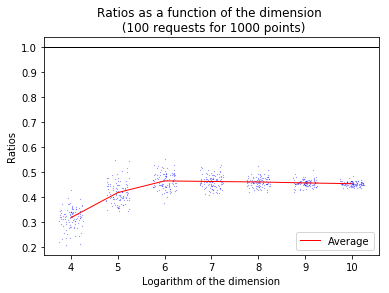

In [15]:
N = 1000
M = 100
D = 3

results = ratios_hypersphere_hub_dataframe(N, M, exp_end)
plot_ratios(results, N, M, exp_end)

Le ratio ne tend plus vers 1, en effet, le hub étant toujours proche, et le anti hub toujours loin, le ratios augmente peu avec la dimension.

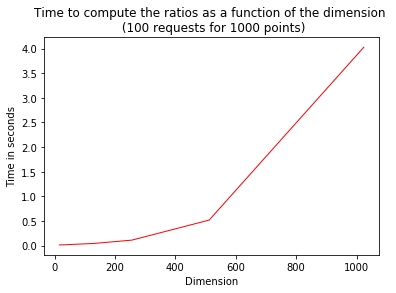

In [16]:
plot_time(results, N, M, exp_end)

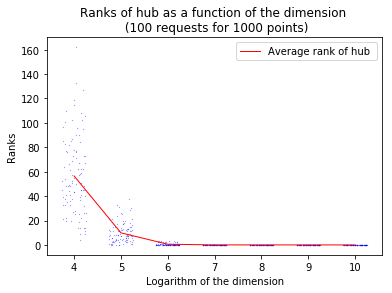

In [17]:
plot_hub_ranks(results, N, M, exp_end)

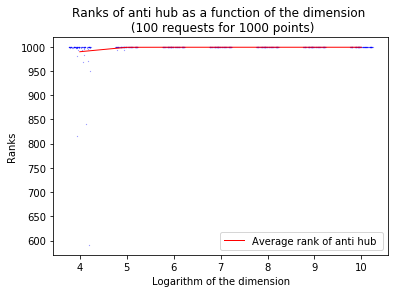

In [18]:
plot_anti_hub_ranks(results, N, M, exp_end)

Les deux graphiques ci-dessus corroborent les conjectures de la question précédente.

## Question 6 (bonus)

In [19]:
def ratios_moving_point_dataframe(nb_data, nb_requests, exp_end):
    """
    Génère la table de données contenant les rangs des 10 points entre le hub et le anti-hub.
    """
    results = []
    frames = []
    for i in range(4, exp_end+1):
        dim = 2 ** i
        
        hub = np.ones(dim)
        hub = normalize(hub)
        anti_hub = np.zeros(dim)
        anti_hub[0] = 1
    
        x = random_norm_pos(nb_data -1, dim) 
        y = random_norm_pos(nb_requests, dim) 
        z = dist.cdist(y,x,'euclidean') 
    
        for k in range(10):
            moving_point = (1-k/9)*hub + k/9*anti_hub
            # moving_point est alors situé sur le segment [hub, anti_hub]
            # Il est nécessaire de normaliser ce point pour qu'il soit sur l'hypersphère unité.
            moving_point = normalize(moving_point)
            
            distance = dist.cdist(np.array([moving_point]),y,'euclidean')
            current_ratios = np.concatenate((distance, z.T), axis = 0).T

            index = np.asarray(list(map(np.argsort, current_ratios))) 
            moving_point_ranks = np.fromiter(map(np.argmin, index), dtype=np.int)
            
            frames.append(pd.DataFrame({'K' : k,
                                        'D' : dim,
                                        'Ranks' : moving_point_ranks.tolist()}))                         
    
    return pd.concat(frames)

In [20]:
def plot_moving_point_ranks(res, nb_data, nb_requests, exp_end, k_max):
    """
    Affiche les rangs moyens des 10 points mobiles entre les hub et 
    les anti hub, en fonction de la dimension.
    """
    jitter = np.random.rand(nb_requests)
    means = [[ np.mean(((res[['Ranks']][(res['K'] == k) & (res['D'] == 2**i)]).values), axis = 0)[0]
              for i in range(4, exp_end +1)] 
             for k in range(k_max)]
    
    for k in range(1, k_max -1):
        y = means[k]
        plt.plot(range(4, exp_end+1), y, 'b--', markersize = .3)
    
    y = means[0]
    hub_avg, = plt.plot(range(4, exp_end+1), y, 'r-', markersize = .2)
    
    y = means[-1]
    anti_hub_avg, = plt.plot(range(4, exp_end+1), y, 'orange', markersize = .2)
    plt.legend([anti_hub_avg,hub_avg], ["Average rank of anti hub","Average rank of hub "])
    
    plt.title("Ranks of the moving points a function of the dimension \n (" + 
              str(nb_requests) + " requests for " + 
              str(nb_data) + " points)")
    plt.ylabel("Ranks")
    plt.xlabel("Logaritm of the dimension")
    plt.show()

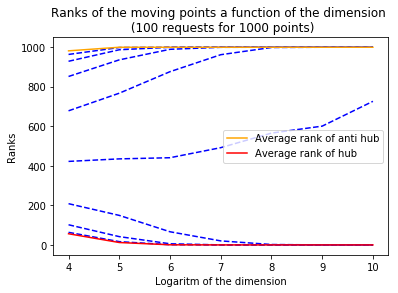

In [21]:
results = ratios_moving_point_dataframe(N, M, 10)
plot_moving_point_ranks(results, N, M, 10, 10)

Le graphique ci dessus représente l'evolution des rangs moyens pour les points situés entre le hub et le anti hub, en fonction de la dimension. On observe que pour k < 4, le point correspondant est un hub pour les hautes dimensions, tandis que pour k > 5, le point correspondant est un anti-hub. <br />
On notera que la distance entre les points mobiles considéres ne varie pas régulièrement à cause de la normalisation effectuée des points sur la corde entre le hub et le anti_hub.

# Partie B:

In [22]:
num_tot = 3212
num_orig = 157
num_test = num_tot - num_orig

# S'assurer que le chemin indiqué en sortie est celui des images de la base copydays
path = "../Images/Copydays/"
print(os.path.abspath(path))

/home/clegrand/Travail/2017/second_semestre/Images/Copydays


In [23]:
images = []

for image in os.listdir(path):
    images.append(image)
    
def get_dim_steps(color):
    
    """Renvoie les bonnes valeurs des dimensions à tester selon que les images soient en couleur ou pas."""
    
    if color:
        dim_steps = [2, 4, 8, 10, 13, 16, 20] # valeurs de la question 8
    else:
        dim_steps = [5, 10, 50, 100, 150, 200, 256] # valeurs de la question 7
    return dim_steps

def hellinger(p, q):
    
    """Calcule la distance de Hellinger entre deux vecteurs."""
    
    _SQRT2 = np.sqrt(2) # sqrt(2) with default precision np.float64
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

def hellinger_mat(A, B):
    
    """Calcule toutes les distances de chaque vecteur de A à chaque vecteur de B."""
    
    A_x, A_y = A.shape
    B_x, B_y = B.shape
        
    C = np.empty([A_x, B_x])
    
    # A et B doivent avoir le même nombre de colonnes
    for i in range(0, A_x):
        for j in range(0, B_x):
            C[i, j] = hellinger(A[i], B[j])

    return C

FileNotFoundError: [Errno 2] No such file or directory: '../Images/Copydays/'

## Question 7 et 8: Code

In [62]:
def im_hists(dim, color = False, truncated = True, hell = False):

    """
    Créée le tableau des histogrammes de toutes les images (N) et les échantillons (M) avec dim points dans chaque.
    color permet d'importer des images en couleur au lieu d'en nuances de gris.
    truncated permet de définir la façon dont les histogrammes sont adaptés à la dimension requise.
    hell permet d'utiliser la distance de Hellinger au lieu de la distance euclidienne.
    """
    
    # Déclaration de la taille des tableaux des histogrammes
    if color:
        N = np.empty([num_test, dim ** 3])
        M = np.empty([num_orig, dim ** 3])
    else:
        N = np.empty([num_test, dim])
        M = np.empty([num_orig, dim])

    N_i = 0
    M_i = 0

    for image in images:
        
        # Lecture de l'image et création de l'histogramme
        if color:
            img = cv2.imread("%s%s"%(path, image), cv2.IMREAD_COLOR)
            hist = cv2.calcHist([img],[0, 1, 2], None, [dim, dim, dim], [0, 256, 0, 256, 0, 256])    
        else:
            img = cv2.imread("%s%s"%(path, image), cv2.IMREAD_GRAYSCALE)
            if truncated:
                hist = cv2.calcHist([img],[0],None,[256],[0,256])
            else:
                hist = cv2.calcHist([img],[0],None,[dim],[0,256])

        # Normalisation de l'histogramme
        normhist = hist
        cv2.normalize(hist,normhist,norm_type=cv2.NORM_L2);
        
        # Transformation de l'histogramme en colonne
        if color:
            normhist = normhist.flatten()
        else:
            normhist = np.ravel(normhist)
            # Tronque les données si nécessaire
            normhist = normhist[:dim]

        # Ajout de l'histogramme à la matrice pertinente
        if image[:17] == "Copydays_original":
            M[M_i] = normhist
            M_i = M_i + 1
        else:
            N[N_i] = normhist
            N_i = N_i + 1

    return N, M

def im_ratios(dim, color = False, truncated = True, hell = False):
    
    """Calcul des ratios min/max pour chaque échantillon."""
    
    t0 = time.clock() # temps du processeur
    N, M = im_hists(dim, color, truncated, hell)
    
    if hell:
        z = hellinger_mat(M,N) # Distance de Hellinger
    else:
        z = dist.cdist(M,N,'euclidean') # Distance euclidienne
    
    minimums=z.min(1)
    maximums=z.max(1)
    time_taken = time.clock() - t0
    
    return pd.DataFrame({'Ratios' : (minimums/maximums).tolist(), 
                         'Elapsed' : time_taken, 
                         'D' : dim})

def im_ratios_dataframe(color = False, truncated = True, hell = False):
    
    """Créée une dataframe contenant les valeurs des rations pour toutes les dimensions demandées."""
    
    im_results = []
    im_frames = []

    dim_steps = get_dim_steps(color)
    
    for dim in dim_steps:
        im_frames.append(im_ratios(dim, color, truncated, hell))

    return pd.concat(im_frames)

def plot_im_ratios(im_res, is_color = False, is_truncated = True, hell = False):
    
    """Créée le graphique des ratios min/max en fonction de la dimension pour les images fournies"""
    
    means = []
    jitter = np.random.rand(num_orig)
    
    str_type = ""
    str_trunc = ""
    str_dist = ""
    
    if hell:
        str_dist += "\nHellinger distance used"
    else:
        str_dist += "\nEuclidean distance used"
    
    if is_color:
        str_type = " color"
    else:
        str_type = " grayscale"
        if is_truncated:
            str_trunc += "\nNumber of cells of histogram truncated to match dimension"
        else:
            str_trunc += "\nNumber of bins of histogram match dimension"

    dim_steps = get_dim_steps(is_color)
    dim_diff = dim_steps[1] - dim_steps[0]
    
    for dim in dim_steps:
        # Jitter pour visualiser les points individuels sur le graphique
        x = (jitter - 0.5) * .5 * dim_diff + dim
        y = (im_res['Ratios'][(im_res['D'] == dim)].values)

        plt.plot(x, y, 'b.', markersize = .3)
        means.append(np.mean(y))

    avg, = plt.plot(dim_steps, means, linewidth= 1, color = 'red')
    plt.title("Ratios as a function of the dimension\n(" +
              str(num_orig) + " requests for " +
              str(num_tot) + str_type + " images)" +
             str_trunc + str_dist)
    
    if is_color:
        plt.xlabel("Bins per color channel")
    else:
        plt.xlabel("Dimension")
    
    plt.ylabel("Ratios")
    plt.legend([avg], ["Average"])
    plt.show()

## Question 7: Résultats

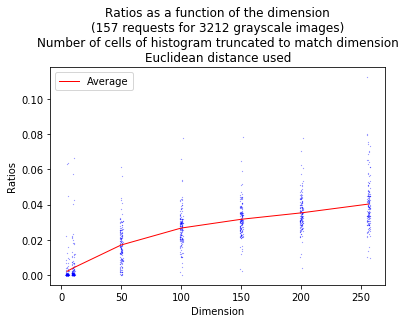

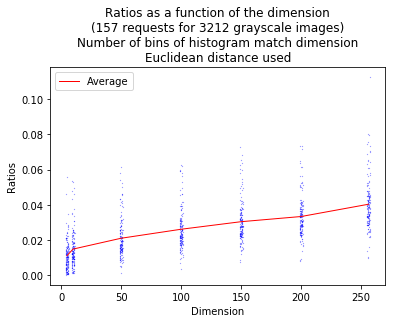

In [63]:
im_res_GA = im_ratios_dataframe(False, True)
im_res_GB = im_ratios_dataframe(False, False)

plot_im_ratios(im_res_GA, False, True)
plot_im_ratios(im_res_GB, False, False)

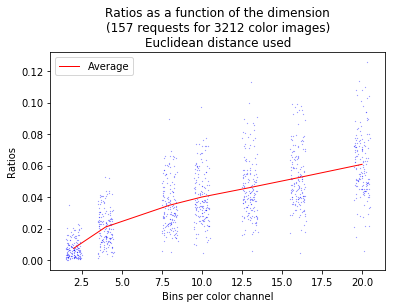

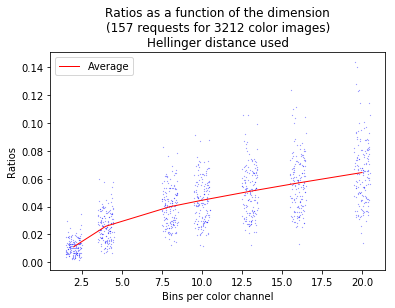

In [72]:
plot_im_ratios(im_res_C, True, True)
plot_im_ratios(im_res_C_H, True, True, True)

Nous remarquons sur le premier graphique que de nombreux points ont un ratio de 0. Ceci est dû au fait que pour ajuster la dimension des points, nous avons choisi de tronquer l'histogramme. Souvent, surtout quand on se limite aux 5 premières valeurs de l'histogramme, on obtient des vecteurs identiques à l'échantillon utilisé pour calculer les distances, la distance à l'échantillon est alors nulle, donc le ratio aussi.

Ce phénomène n'apparaît pas quand on fait varier la taille des "bins" de l'histogramme puisque tous les niveaux de gris possibles sont considérés, on a une représentation moins précise de l'image, mais qui prend en compte toutes les couleurs possibles.

## Question 8: Résultats

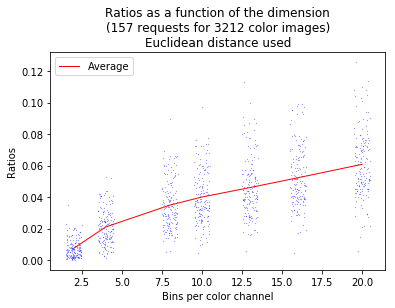

In [64]:
im_res_C = im_ratios_dataframe(True)

plot_im_ratios(im_res_C, True)

## Question 9

In [67]:
def ratios_dataframe_steps(nb_data, nb_requests, color = False):
    
    """Créée une dataframe à partir de points aléatoires distribués uniformément dans l'hypercube unité de dimension spécifiée."""
    
    results = []
    frames = []
    
    dim_steps = get_dim_steps(color)

    for dim in dim_steps:
        if color:
            real_dim = dim ** 3
        else:
            real_dim = dim
        frames.append(ratios(nb_data, nb_requests, real_dim))
    return pd.concat(frames)

def plot_comp_ratios(im_res, syn_res, is_color = False, is_truncated = True, is_hell = False):
    
    """Créée le graphique comparant les ratios pour les images fournies et les données synthétiques."""
    
    means_real = []
    means_synth = []
    jitter = np.random.rand(num_orig)
    
    str_type = ""
    str_trunc = ""
    str_dist = ""
    
    if is_hell:
        str_dist += "\nHellinger distance used"
    else:
        str_dist += "\nEuclidean distance used"
    
    if is_color:
        str_type = " color"
    else:
        str_type = " grayscale"
        if is_truncated:
            str_trunc += "\nNumber of cells of histogram truncated to match dimension"
        else:
            str_trunc += "\nNumber of bins of histogram match dimension"

    dim_steps = get_dim_steps(is_color)
    dim_diff = dim_steps[1] - dim_steps[0]
    
    for dim in dim_steps:
        x = (jitter - 0.5) * .5 * dim_diff + dim
        if is_color:
            real_dim = dim ** 3
        else:
            real_dim = dim
        y_im = (im_res['Ratios'][(im_res['D'] == dim)].values)
        y_syn = (syn_res['Ratios'][(syn_res['D'] == real_dim)].values)
        
        plt.plot(x, y_im, 'b.', markersize = .3)
        plt.plot(x, y_syn, 'g.', markersize = .3)
        means_real.append(np.mean(y_im))
        means_synth.append(np.mean(y_syn))

    avg_real, = plt.plot(dim_steps, means_real, linewidth= 1, color = 'red')
    avg_synth, = plt.plot(dim_steps, means_synth, linewidth= 1, color = 'orange')
    
    plt.title("Ratios as a function of the dimension\n(" +
              str(num_orig) + " requests for " +
              str(num_tot) + str_type + " images)" +
             str_trunc + str_dist)
    
    if is_color:
        plt.xlabel("Bins per color channel")
    else:
        plt.xlabel("Dimension")
    plt.ylabel("Ratios")
    plt.legend([avg_real, avg_synth], ["Images average", "Synth. average"])
    plt.show()

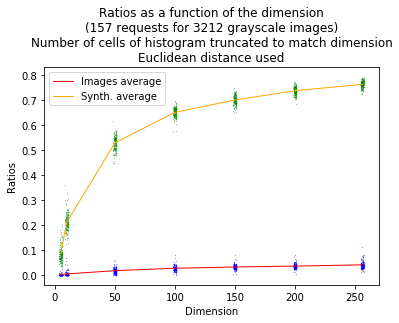

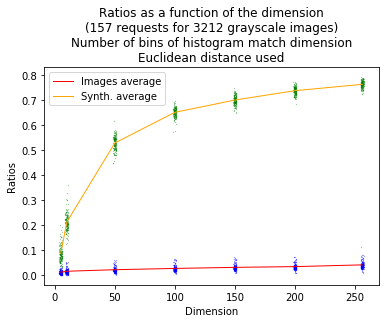

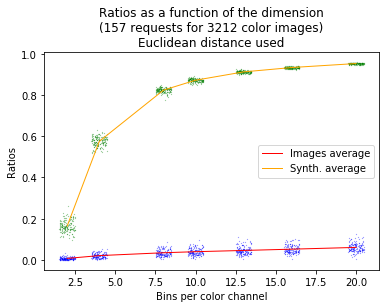

In [68]:
res_G = ratios_dataframe_steps(num_test, num_orig, False)
res_C = ratios_dataframe_steps(num_test, num_orig, True)

plot_comp_ratios(im_res_GA, res_G, False, True)
plot_comp_ratios(im_res_GB, res_G, False, False)
plot_comp_ratios(im_res_C, res_C, True, False)

## Question 10

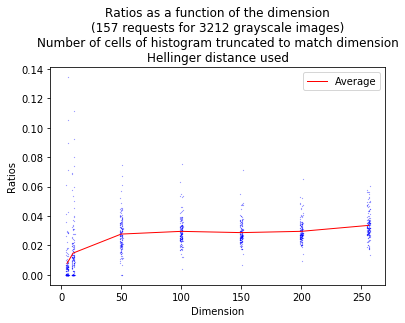

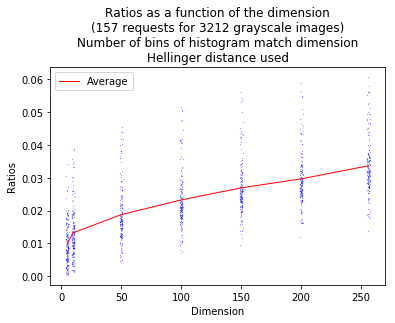

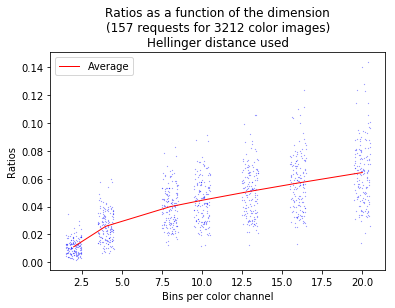

In [69]:
im_res_GA_H = im_ratios_dataframe(False, True, True)
im_res_GB_H = im_ratios_dataframe(False, False, True)
im_res_C_H = im_ratios_dataframe(True, False, True)

plot_im_ratios(im_res_GA_H, False, True, True)
plot_im_ratios(im_res_GB_H, False, False, True)
plot_im_ratios(im_res_C_H, True, False, True)

Nous remarquons que l'utilisation de la distance de Hellinger pour les images en nuances de gris réduit le ratio min/max par rapport à la distance euclidienne, ce qui est cohérent puisque l'amplitude des composantes des histogrammes est relativement élevée et donc la racine carrée réduit de façon significative cette amplitude, ce qui provoque la réduction du ratio.

Par ailleurs, le ratio est similaire avec les deux distances pour les images en couleur, puisque l'amplitude des composantes est beaucoup plus faible que pour les images en nuances de gris, le nombre de bins total de l'histogramme étant beaucoup plus élevé. La racine ne réduit donc que très peu cette amplitude, ce qui a pour conséquence de garder des ratios min/max similaires.

## Question 11

Nous observons qu'en comparaison aux ratios obtenus pour les données synthétiques, les ratios obtenus pour les images croissent très lentement. Par exemple, pour les images en couleur, nous observons que le ratio moyen pour 8000 dimensions est de 0,06 pour la distance euclidienne, alors que pour les données synthétiques il est supérieur à 0,9.

Il est nécessaire pour comprendre correctement ce résultat de comparer les distributions des points utilisés:
* les données synthétiques sont piochées de façon uniforme dans l'hypercube unité
* les images fournies sont des légères modifications effectuées à partir des images contenant "original" dans le titre, on peut donc imaginer que les points sont regroupés dans l'espace autour de l'image original de laquelle ils sont tirés.

Ainsi il est difficile de confronter ces deux ensembles de données, étant donné que les distributions sont très différentes. En effet, pour les images, du fait que certaines images sont toujours très proches de leur image originale quelle que soit la dimension, alors que d'autres images provenant d'images originales très différentes seront toujours très loin.

Les effets de la "malédiction de la dimensionnalité" se trouvent alors fortement mitigés. Il serait intéressant de voir pour quel ordre de grandeur de la dimension il serait possible d'atteindre pour notre ensemble d'images un ratio min/max supérieur à 0,9.